In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= SETTINGS =========
CAND_FILE = "../src_csv/xau_m5_candidates_ea3.csv"
M1_FILE   = "../src_csv/not_used/m1_2025-20260220.csv"
# M1_FILE   = "../src_csv/m1_master.csv"

POINT = 0.01
USD_PER_POINT = 0.01
START_BALANCE = 100.0

SL_PTS = 800
TP_PTS = 1800
MAX_MINUTES = 60
EARLY_MINUTES = 60

SL_TO_STOP = 1          # 🔴 stop after N SL
STOP_MODE = "session"   # "session" or "day"

SPREAD_PTS = 8
SPREAD = SPREAD_PTS * POINT

START_ALL = "2026-01-01 00:00"
END_ALL   = "2026-02-20 23:59"
# =================================

In [349]:
# ===== LOAD =====
cand = pd.read_csv(CAND_FILE)
cand.columns = cand.columns.str.strip()
cand["time"] = pd.to_datetime(cand["time"])
cand = cand.sort_values("time")

m1 = pd.read_csv(M1_FILE)
m1.columns = m1.columns.str.strip()
m1["time"] = pd.to_datetime(m1["time"])
m1 = m1.sort_values("time").set_index("time")

cand = cand[
    (cand["time"] >= START_ALL) &
    (cand["time"] <= END_ALL)
].copy()

In [350]:
# ===== SESSION =====
def get_session(h):
    if 0 <= h < 8: return "Asia"
    elif 8 <= h < 16: return "Europe"
    else: return "America"

cand["hour"] = cand["time"].dt.hour
cand["session"] = cand["hour"].apply(get_session)
cand["date"] = cand["time"].dt.date


# ===== SIM =====
def simulate_one(t0, side):

    t_entry = t0 + pd.Timedelta(minutes=4)
    if t_entry not in m1.index:
        return ("NO_ENTRY", np.nan)

    entry_close = float(m1.loc[t_entry]["close"])

    if side == "BUY":
        entry = entry_close + SPREAD/2
        sl = entry - SL_PTS*POINT
        tp = entry + TP_PTS*POINT
    else:
        entry = entry_close - SPREAD/2
        sl = entry + SL_PTS*POINT
        tp = entry - TP_PTS*POINT

    future = m1.loc[t_entry:].iloc[1:MAX_MINUTES+1]

    for i, (_, row) in enumerate(future.iterrows(), start=1):

        close_price = float(row["close"])
        bid = close_price - SPREAD/2
        ask = close_price + SPREAD/2

        if side == "BUY":
            if bid <= sl: return ("SL", -SL_PTS)
            if bid >= tp: return ("TP", TP_PTS)
        else:
            if ask >= sl: return ("SL", -SL_PTS)
            if ask <= tp: return ("TP", TP_PTS)

        if EARLY_MINUTES and i >= EARLY_MINUTES:
            profit = (bid-entry)/POINT if side=="BUY" else (entry-ask)/POINT
            if profit > 0:
                return ("EARLY", profit)

        if i >= MAX_MINUTES:
            profit = (bid-entry)/POINT if side=="BUY" else (entry-ask)/POINT
            return ("TIME", profit)

    return ("NO_DATA", np.nan)

In [351]:
# ===== BACKTEST ENGINE =====
def run_backtest(cand):

    results = []
    sl_counter = {}
    blocked = set()

    for row in cand.itertuples():

        if STOP_MODE == "session":
            key = (row.date, row.session)
        else:
            key = row.date

        if key in blocked:
            results.append(("BLOCKED", np.nan, 0))
            continue

        reason, pts = simulate_one(row.time, row.side)

        if np.isnan(pts):
            results.append((reason, np.nan, 0))
            continue

        pnl = pts * USD_PER_POINT
        results.append((reason, pts, pnl))

        if reason == "SL":
            sl_counter[key] = sl_counter.get(key, 0) + 1
        else:
            sl_counter[key] = 0

        if sl_counter[key] >= SL_TO_STOP:
            blocked.add(key)

    return results

In [352]:
# ===== RUN =====
results = run_backtest(cand)

cand["exit_reason"] = [r[0] for r in results]
cand["points"]      = [r[1] for r in results]
cand["pnl_usd"]     = [r[2] for r in results]
cand["win"]         = cand["pnl_usd"] > 0

cand["balance"] = START_BALANCE + cand["pnl_usd"].cumsum()

master = cand.dropna(subset=["points"]).copy()

In [353]:
# =====================================================
# =============== MASTER FILTER TABLE =================
# =====================================================

master = cand.dropna(subset=["points"]).copy()

In [354]:
# ================= DASHBOARD =================

def show_dashboard(df):
    
    print("\n====== FINAL RESULTS ======")
    print(f'{df["time"].min()} - {df["time"].max()}')
    print("===========================")
    print("Start balance:", START_BALANCE)
    print("End balance:", START_BALANCE + df["pnl_usd"].sum())
    print("Total PnL:", df["pnl_usd"].sum())
    print("Total trade:", len(df))
    print("Total win:", (df["points"] > 0).sum())
    print("Total loss:", (df["points"] < 0).sum())
    print()
    print("Avg. PnL:", df["pnl_usd"].mean())
    print("Winrate:", (df["points"] > 0).mean())

    equity = START_BALANCE + df["pnl_usd"].cumsum()
    drawdown = equity.cummax() - equity
    print("Max Drawdown:", drawdown.max())

    # Equity
    plt.figure()
    plt.plot(equity.values)
    plt.title("Equity Curve")
    plt.show()

    # Session PnL
    pivot = df.groupby(["session","side"])["points"].sum().unstack()
    pivot.plot(kind="bar")
    plt.title("Net Points by Session & Side")
    plt.show()

    # Daily
    daily = df.groupby("date")["pnl_usd"].sum()
    plt.figure()
    plt.bar(daily.index.astype(str), daily.values)
    plt.xticks(rotation=90)
    plt.title("Daily PnL")
    plt.show()


====== FINAL RESULTS ======
2026-01-02 01:00:00 - 2026-02-20 16:30:00
Start balance: 100.0
End balance: 1933.4500000000153
Total PnL: 1833.4500000000153
Total trade: 425
Total win: 258
Total loss: 166

Avg. PnL: 4.314000000000036
Winrate: 0.6070588235294118
Max Drawdown: 74.90999999999804


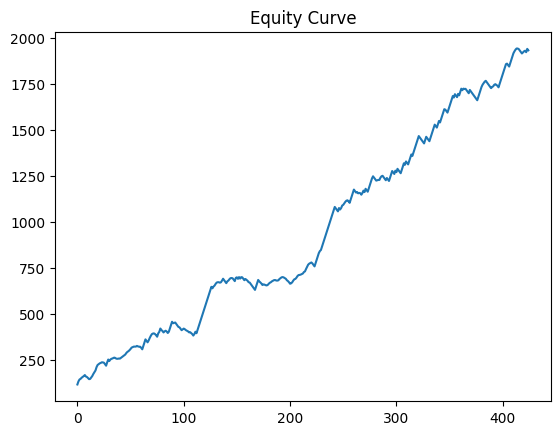

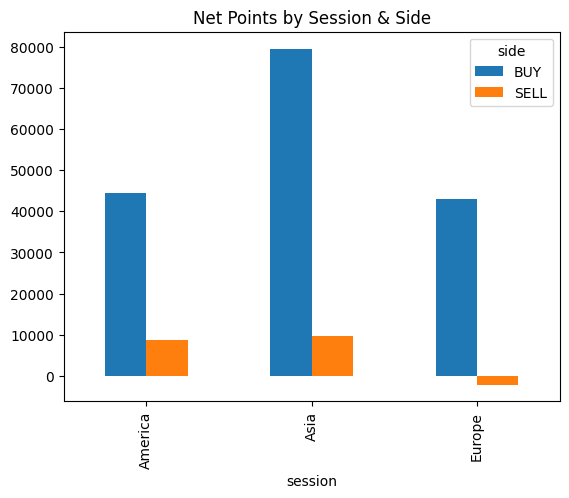

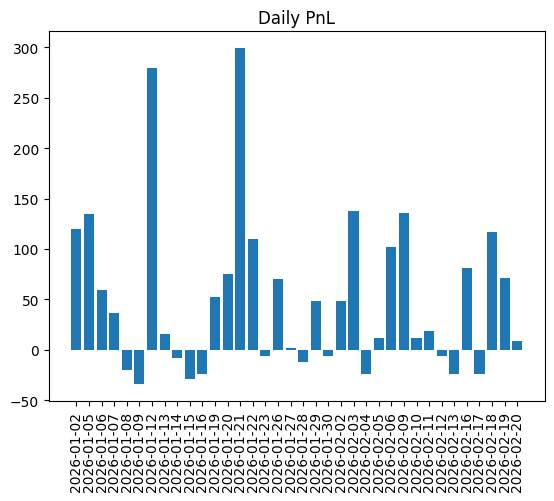

In [355]:
# ===== USE FILTER HERE =====
filtered = master.copy()

# Example filters:
# filtered = master[master["session"]=="America"]
# filtered = master[master["side"]=="BUY"]
# filtered = master[(master["session"]=="America") & (master["side"]=="BUY")]

show_dashboard(filtered)

In [356]:
filtered

,time,side,spread_pts,r1,r2,r3,r4,r5,r6,r7,...,r9,r10,hour,session,date,exit_reason,points,pnl_usd,win,balance
32111,2026-01-02 01:00:00,BUY,4,851.0,178.0,263.0,-18.0,-114.0,384.0,212.0,...,-171.0,-324.0,1,Asia,2026-01-02,TP,1800.0,18.00,True,118.00
32112,2026-01-02 01:05:00,BUY,4,583.0,851.0,178.0,263.0,-18.0,-114.0,384.0,...,188.0,-171.0,1,Asia,2026-01-02,EARLY,1689.0,16.89,True,134.89
32113,2026-01-02 01:15:00,BUY,4,339.0,-227.0,583.0,851.0,178.0,263.0,-18.0,...,384.0,212.0,1,Asia,2026-01-02,EARLY,1024.0,10.24,True,145.13
32114,2026-01-02 01:20:00,BUY,4,569.0,339.0,-227.0,583.0,851.0,178.0,263.0,...,-114.0,384.0,1,Asia,2026-01-02,EARLY,344.0,3.44,True,148.57
32115,2026-01-02 01:25:00,BUY,4,106.0,569.0,339.0,-227.0,583.0,851.0,178.0,...,-18.0,-114.0,1,Asia,2026-01-02,EARLY,614.0,6.14,True,154.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37019,2026-02-20 08:10:00,BUY,4,362.0,-214.0,316.0,445.0,49.0,772.0,-388.0,...,98.0,4.0,8,Europe,2026-02-20,EARLY,593.0,5.93,True,1928.23
37020,2026-02-20 08:15:00,BUY,4,46.0,362.0,-214.0,316.0,445.0,49.0,772.0,...,71.0,98.0,8,Europe,2026-02-20,EARLY,322.0,3.22,True,1931.45
37021,2026-02-20 08:20:00,BUY,4,497.0,46.0,362.0,-214.0,316.0,445.0,49.0,...,-388.0,71.0,8,Europe,2026-02-20,SL,-800.0,-8.00,False,1923.45
37065,2026-02-20 16:05:00,BUY,4,458.0,-321.0,-201.0,451.0,991.0,205.0,516.0,...,-147.0,95.0,16,America,2026-02-20,TP,1800.0,18.00,True,1941.45
